# Police Shootings in the United States
Police brutality is widely considered to be a serious problem in the United States of America. According to The Washington Post, Mapping Police Violence Project, and Statista, during the years 2020-2022 there were over 1,000 police murders annually. However, in order to address this society-wide problem, we must analyze the features of the violence to assess proximate causes. 

This analysis seeks to ask: <br>
_Are there trends that define the nature of police violence?_

National protests and historical movements have centered on the ___racial component___ of police murder. 

So, we will ask, given the data provided:
- __is there a racial bias to police violence in the US?__ 
- If so, then __under what conditions is there a racial component to police murder?__

In this analysis, we will focus on fatal police shootings in the United States using data collected by the Washington Post. 

Beyond investigating the racial attributes of the police violence, <br>
we will also perform a location-based analysis to ask:
- __where in the USA does police violence occur?__

Next, we will perform a time-series analysis to determine:<br> 
- ___are any trends that define how police violence has changed from 2015 to 2023?___

Moreover, we will attempt to look at relationships between these different components of police murder, again with a specific emphasis on race and location. 

In the current analysis, we will address these questions and more in order to provide a list of issues that relate to police murder in the USA and attempt to approach solutions to address this serious issue.

Data Source: [__Fatal Force Database (v2) - Washington Post__](https://github.com/washingtonpost/data-police-shootings/tree/master/v2)
***

In [1]:
import datetime as dt

import folium
import geopandas
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
# **this cell is optional **
# remove warnings
# FOR CODE DISPLAY ONLY

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

__Download the dataset and read it into a DataFrame using Pandas.__

In [3]:
url = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv'
wapo = pd.read_csv(url)

__Take a look at the data__

In [4]:
wapo.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


Early observations:
- there are NaN values, there are also not_available values, I would like to standardize this
- the column names are good. 
- there is good documentation on GitHub regarding the variables and their contents 
- I won't use ID as a variable

In [5]:
# drop ID column

del wapo['id']

In [6]:
wapo.head()

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


__assess data quality: data types, missing values, duplicate information__

how do I want to deal with "not_available"?

According to the documentation 'location_precision' and 'race_source' columns contain these values, their meaning is mentioned below: 

- First, I want to see: what columns contain "not_available"<br><br>
- Second, how many of these values are "not_available" <br><br>
- Since these are non-numeric values, I think "not_available" is a suitable phrase at this stage
<br><br>
As well, I would like to check numerical columns for null values. 

In [7]:
# 'not_available' indicates that Location was entered before current methodology was established.
#
# whereas 'nan' indicates that the data is missing. I will create a category called 'data_missing',
# so as not to lose these individuals in analyses downstream such as counts

wapo['location_precision'].unique()

array(['not_available', 'block', nan, 'intersection', 'address',
       'poi_small', 'road', 'poi_large'], dtype=object)

In [8]:
wapo['location_precision'].fillna('data_missing', inplace=True)

In [9]:
# 'not_available' indicates older records which have race populated but The Post does not have details
# on the methodology because it was collected before the current structure was introduced.
#
# nan indicates that this individual's race is not provided
#
# undetermined indicates that when The Post's race research avenues have been exhausted and race is still unknown,
# this indicates that race is still unknown, but research is complete.

wapo['race_source'].unique()

array(['not_available', nan, 'photo', 'clip', 'public_record', 'other',
       'undetermined'], dtype=object)

In [10]:
# I will rename np.nan as "undetermined" since these columns fundamentally mean the same thing
wapo['race_source'].fillna('undetermined', inplace=True)

In [11]:
# to assess race, I will create a category called "unknown"
wapo['race'].unique()

array(['A', 'W', 'H', 'B', 'O', nan, 'N', 'W;B;N', 'N;H', 'W;H', 'B;H',
       'W;B', 'W;A'], dtype=object)

In [12]:
wapo['race'].fillna('unknown', inplace=True)

In [13]:
wapo['race'].unique()

array(['A', 'W', 'H', 'B', 'O', 'unknown', 'N', 'W;B;N', 'N;H', 'W;H',
       'B;H', 'W;B', 'W;A'], dtype=object)

In [14]:
# Is there any other missing data in this dataset?

# this will give the columns with null values

wapo.isnull().any()

date                          False
threat_type                    True
flee_status                    True
armed_with                     True
city                           True
county                         True
state                         False
latitude                       True
longitude                      True
location_precision            False
name                           True
age                            True
gender                         True
race                          False
race_source                   False
was_mental_illness_related    False
body_camera                   False
agency_ids                     True
dtype: bool

For these remaining columns with null values I will allow np.nan to stay in the data and take this into account as I proceed with my analysis

In [15]:
# what types are in the data?
wapo.dtypes

date                           object
threat_type                    object
flee_status                    object
armed_with                     object
city                           object
county                         object
state                          object
latitude                      float64
longitude                     float64
location_precision             object
name                           object
age                           float64
gender                         object
race                           object
race_source                    object
was_mental_illness_related       bool
body_camera                      bool
agency_ids                     object
dtype: object

In [16]:
# make "date" column a datetime object

wapo["date"] = pd.to_datetime(wapo["date"])
wapo.dtypes

date                          datetime64[ns]
threat_type                           object
flee_status                           object
armed_with                            object
city                                  object
county                                object
state                                 object
latitude                             float64
longitude                            float64
location_precision                    object
name                                  object
age                                  float64
gender                                object
race                                  object
race_source                           object
was_mental_illness_related              bool
body_camera                             bool
agency_ids                            object
dtype: object

In [17]:
# convert categorical variables to "category" dtype
categorical_columns = [
    'threat_type', 'flee_status', 'armed_with', 'city', 'county', 'state',
    'location_precision', 'name', 'gender', 'race', 'race_source', 'agency_ids'
]
wapo[categorical_columns] = wapo[categorical_columns].astype('category')

In [18]:
boolean_columns = ['was_mental_illness_related', 'body_camera']
wapo[boolean_columns] = wapo[boolean_columns].astype('boolean')

In [19]:
wapo.dtypes

date                          datetime64[ns]
threat_type                         category
flee_status                         category
armed_with                          category
city                                category
county                              category
state                               category
latitude                             float64
longitude                            float64
location_precision                  category
name                                category
age                                  float64
gender                              category
race                                category
race_source                         category
was_mental_illness_related           boolean
body_camera                          boolean
agency_ids                          category
dtype: object

In [20]:
# I find this B;H category to be odd, so I investigate it further

wapo[wapo['race'].str.match('B;H')]

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
7704,2022-08-28,point,NaN,gun,Albuquerque,NaN,NM,35.114986,-106.702226,not_available,Keshawn Thomas,27.0,male,B;H,clip,False,False,508
8109,2023-01-06,threat,not,knife,Roswell,Chaves,NM,33.379574,-104.532695,block,Nickolas Acosta,20.0,male,B;H,photo,False,False,686


In [21]:
# Based on the information available I feel comfortable coverting 'B;H' to 'B' for this one unique case

wapo.loc[wapo['race'] == 'B;H', 'race'] = 'B'

In [22]:
# This same type of categorization occurs a few times, and for each case I will recategorize according to one of the present categories or to unknown:
wapo.loc[wapo['race'] == 'W;B;N', 'race'] = 'unknown'
wapo.loc[wapo['race'] == 'N;H', 'race'] = 'H'
wapo.loc[wapo['race'] == 'W;H', 'race'] = 'H'
wapo.loc[wapo['race'] == 'B;H', 'race'] = 'H'
wapo.loc[wapo['race'] == 'W;B', 'race'] = 'B'
wapo.loc[wapo['race'] == 'W;A', 'race'] = 'A'

In [23]:
wapo['race'] = wapo['race'].cat.remove_unused_categories()

In [24]:
wapo['race'].unique()

['A', 'W', 'H', 'B', 'O', 'unknown', 'N']
Categories (7, object): ['A', 'B', 'H', 'N', 'O', 'W', 'unknown']

In [25]:
wapo['race'].replace(
    {
        'A': 'Asian',
        'B': 'Black',
        'H': 'Hispanic',
        'N': 'Native_American',
        'O': 'Other',
        'W': 'White'
    },
    inplace=True)

__check data for duplicate values__

In [26]:
# Are there any duplicates?

print("Is there any duplicated data?: ", wapo.duplicated().any())
print("Are there any duplicated columns?: ", wapo.columns.duplicated().any())

Is there any duplicated data?:  False
Are there any duplicated columns?:  False



now the data looks good and is ready to be worked with.
***

In [27]:
# For the current analysis we will only look at data from 2015-2023

wapo = wapo[(wapo['date'] >= '2015-01-01') & (wapo['date'] <= '2023-12-31')]

# Statistical Summary

In [28]:
wapo.describe(include='all')

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
count,9251,9186,8001,9043,9181,4558,9251,8228.000000,8228.000000,9251,8987,8935.000000,9231,9251,9251,9251,9251,9251
unique,NaN,8,4,23,3481,896,51,NaN,NaN,8,8944,NaN,3,7,6,2,2,3563
top,NaN,shoot,not,gun,Los Angeles,Los Angeles,CA,NaN,NaN,not_available,Michael Johnson,NaN,male,White,not_available,False,False,38
freq,NaN,2609,4963,5382,146,189,1294,NaN,NaN,7068,5,NaN,8820,4257,6193,7373,7694,132
mean,2019-08-18 15:09:12.199762176,NaN,NaN,NaN,NaN,NaN,NaN,36.636767,-97.005400,NaN,NaN,37.375042,NaN,NaN,NaN,NaN,NaN,NaN
min,2015-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,19.497503,-160.006944,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,2017-05-09 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,33.462103,-112.005383,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,2019-09-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,36.071374,-94.349910,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2021-12-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,40.013060,-83.191573,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,2023-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,71.301255,-67.867166,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,NaN,NaN


***
###  Set My Default Theme for Plots

In [29]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlesize": 18
}

sns.set_theme(context='notebook',
              style='ticks',
              palette='deep',
              font='sans-serif',
              font_scale=1,
              color_codes=True,
              rc=custom_params)

*** 
# Race Analysis
***

In [30]:
wapo['race'].describe()

count      9251
unique        7
top       White
freq       4257
Name: race, dtype: object

In [31]:
race_counts = wapo['race'].value_counts(dropna=False)
print(race_counts)

race
White              4257
Black              2226
Hispanic           1539
unknown             899
Asian               172
Native_American     130
Other                28
Name: count, dtype: int64


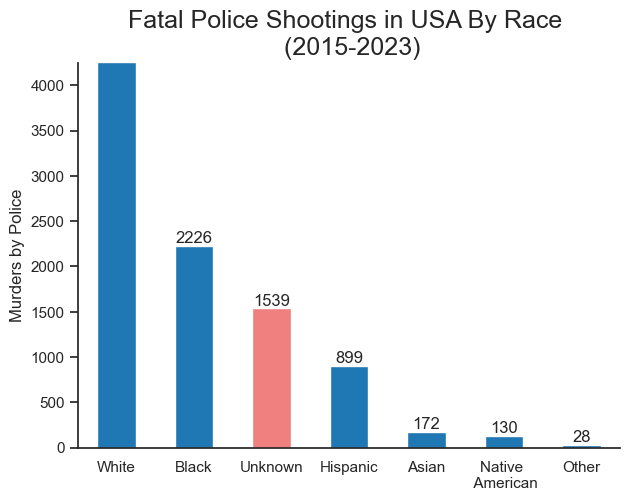

In [32]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()

race_counts.plot(kind="bar",
                 title="Fatal Police Shootings in USA By Race \n (2015-2023)",
                 rot=0,
                 xlabel="",
                 ylabel="Murders by Police",
                 ylim=(0, 4250),
                 ax=ax,
                 color=[
                     '#1f77b4', '#1f77b4', 'lightcoral', '#1f77b4', '#1f77b4',
                     '#1f77b4', '#1f77b4'
                 ])

ax.bar_label(ax.containers[0])
ax.set_xticklabels([
    'White', 'Black', 'Unknown', 'Hispanic', 'Asian', 'Native \n American',
    'Other'
])
plt.tick_params(bottom=False)

I want to look at the counts of police murders, but per year with different lines representing different races

In [33]:
# get years from datetime variable
years = wapo['date'].dt.year

# create multi-indexed grouping (i.e. a series) by year and race
race_counts_by_year = wapo.groupby([years],
                                   observed=False)['race'].value_counts()
race_counts_by_year.index.rename(['year', 'race'], inplace=True)
race_counts_by_year.rename('murders', inplace=True)
race_counts_by_year

year  race           
2015  White              505
      Black              258
      Hispanic           176
      unknown             19
      Asian               17
                        ... 
2023  unknown            213
      Hispanic           165
      Asian               20
      Native_American     12
      Other                5
Name: murders, Length: 63, dtype: int64

In [34]:
# convert race_counts_by_year to a dataframe for plotting a line chart using Pandas

race_counts_by_year_df = race_counts_by_year.reset_index('race')
race_counts_by_year_df = race_counts_by_year_df.pivot(columns='race',
                                                      values='murders')
race_counts_by_year_df['total'] = race_counts_by_year_df.sum(axis=1)
race_counts_by_year_df

race,Asian,Black,Hispanic,Native_American,Other,White,unknown,total
year,,,,,,,,
2015,17,258,176,10,10,505,19,995
2016,19,239,168,18,2,473,40,959
2017,17,227,191,22,2,464,61,984
2018,26,236,181,16,1,476,55,991
2019,27,257,171,13,3,432,91,994
2020,16,248,175,9,2,467,103,1020
2021,13,253,157,14,1,483,128,1049
2022,17,258,155,16,2,458,189,1095
2023,20,250,165,12,5,499,213,1164


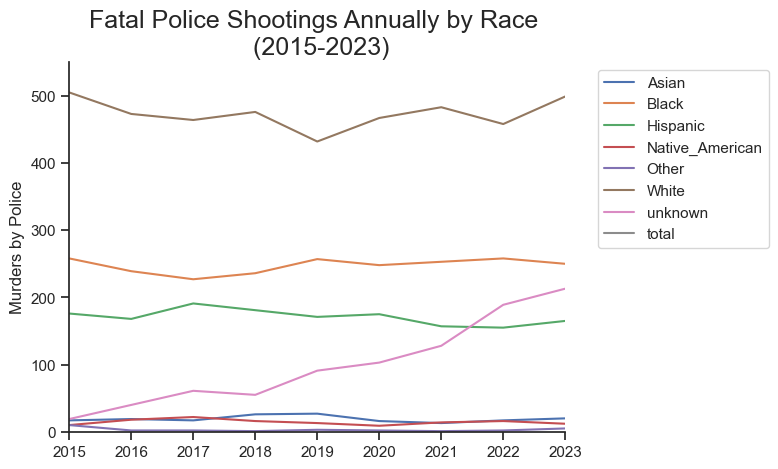

In [35]:
ax = race_counts_by_year_df.plot.line()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis((2015, 2023, 0, 550))
plt.title("Fatal Police Shootings Annually by Race \n (2015-2023)")
plt.xlabel("")
plt.ylabel("Murders by Police");

Alternatively, this same data can be plotted using Plotly.<br>By using Plotly, we can look at this graph on an annual basis and gain useful information.<br><br> For instance, note that since 2020, the "unknown" category seems to be on the rise. Temporally, this seems to concide with a wave of protests in the United States after the murder of George Floyd. 

In [36]:
race_counts_by_year_df = race_counts_by_year.reset_index()
fig = px.line(race_counts_by_year_df,
              x="year",
              y="murders",
              color='race',
              labels={
                  'year': 'Year',
                  'murders': 'Murders by Police'
              },
              title="Fatal Police Shootings Annually by Race (2015-2023)")
fig.show()

In [37]:
# CUMULATIVE SUM ANALYSIS
# to further gain information about the rise of the "unknown" category in 2020, I will plot the cumulative sum
# of the Police Murders

by_race = wapo[['date', 'race']].copy()
by_race['count'] = 1
by_race['count'].sort_index().cumsum()

# Calculate sum of the murders by race

by_race['cumsum_by_race'] = by_race.groupby(['race'],
                                            observed=False)['count'].cumsum()
by_race

,date,race,count,cumsum_by_race
0,2015-01-02,Asian,1,1
1,2015-01-02,White,1,1
2,2015-01-03,Hispanic,1,1
3,2015-01-04,White,1,2
4,2015-01-04,Hispanic,1,2
...,...,...,...,...
9246,2023-12-29,White,1,4255
9247,2023-12-29,White,1,4256
9248,2023-12-31,unknown,1,899
9249,2023-12-31,Hispanic,1,1539


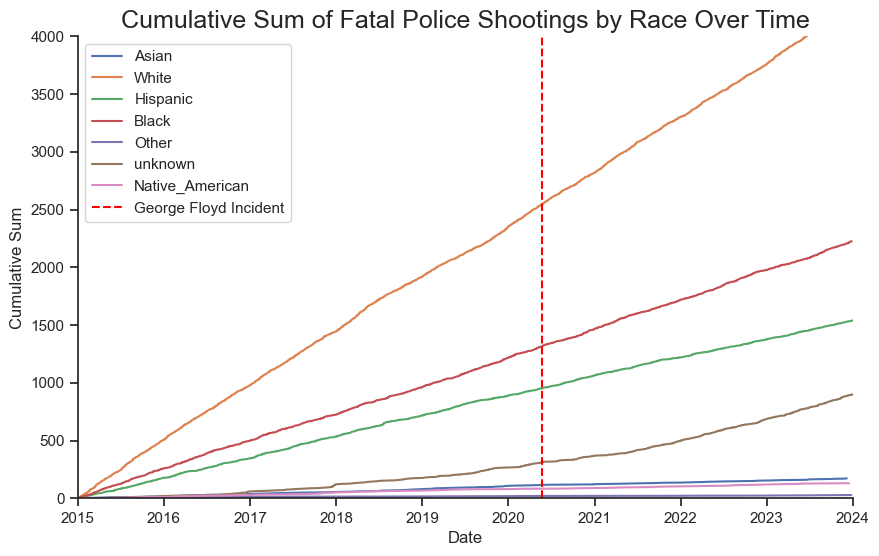

In [38]:
races = [
    'Asian', 'White', 'Hispanic', 'Black', 'Other', 'Unknown',
    'Native American'
]
fig, ax = plt.subplots(figsize=(10, 6))

# Plot cumulative sum by race
for race in by_race['race'].unique():
    tmp_race = by_race[by_race['race'] == race]
    ax.plot(tmp_race['date'], tmp_race['cumsum_by_race'], label=race)

# Add a vertical line at the date of the murder of George Floyd (05/25/2020)
ax.axvline(pd.to_datetime('2020-05-25'),
           color='red',
           linestyle='--',
           label='George Floyd Incident')

ax.legend(labels=races.append('George Floyd Incident'))
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Sum')
ax.set_title('Cumulative Sum of Fatal Police Shootings by Race Over Time')
ax.set_xlim([dt.date(2015, 1, 1), dt.date(2024, 1, 1)])
ax.set_ylim([0, 4000])

plt.show()

### it seems as if there has been an increase in unreported race in the case of fatal police shootings in recent years.

In [39]:
# search for George Floyd murder

george_filter = wapo['name'].str.contains('George', na=False)
date_filter = wapo['date'].dt.year == 2020

wapo[george_filter & date_filter]

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
4934,2020-01-05,point,not,gun,Elkmont,NaN,AL,34.882455,-87.099522,not_available,George Dison,57.0,male,White,not_available,False,False,2675
5722,2020-10-20,point,not,gun,Phoenix,NaN,AZ,33.509295,-112.034533,not_available,George Cocreham,43.0,male,Hispanic,not_available,True,True,80


#### The murder of George Floyd is not on this list because it is not a shooting, future analyses should also focus on brutality cases such as this. 
***

# Location-based Analysis
***

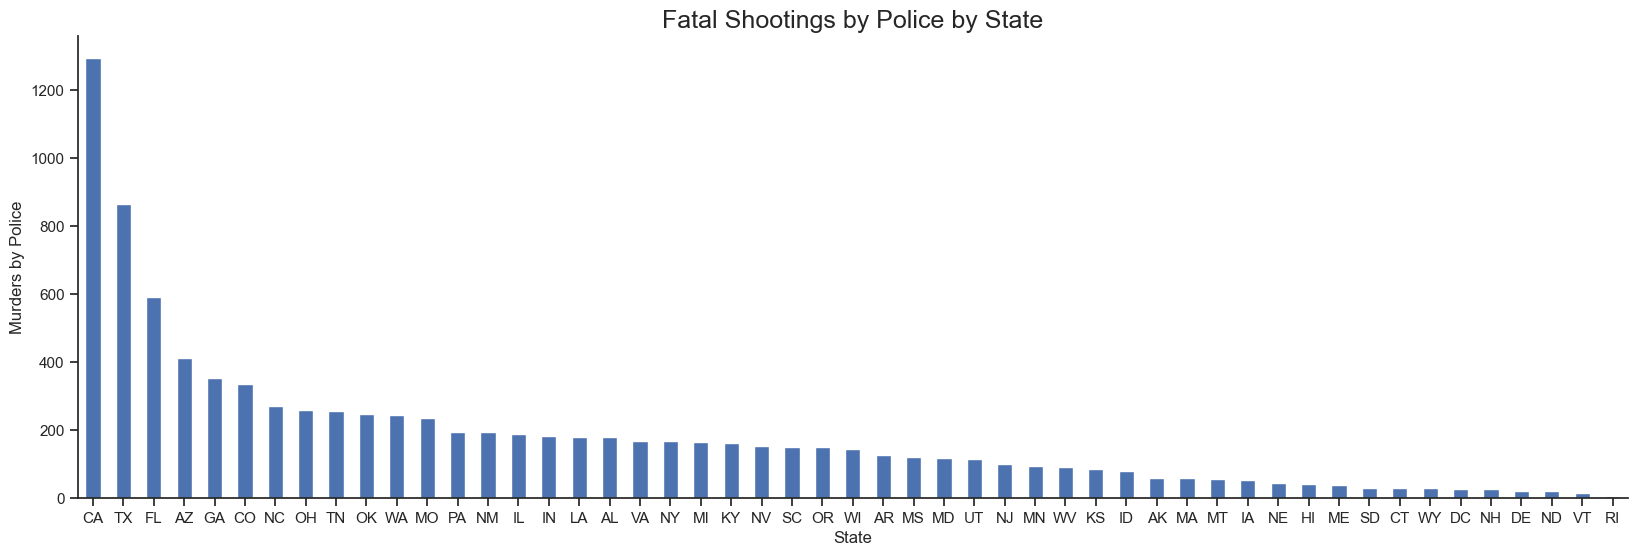

In [40]:
# first, let's just look at the scale of the police murder in each state

wapo['state'].value_counts().plot(kind="bar", figsize=(20, 6), rot=0)
plt.ylabel('Murders by Police')
plt.xlabel('State')
plt.title('Fatal Shootings by Police by State')

plt.show()

In [41]:
# secondly, let's see how this breaks down annually


def plot_states_by_year(year=2015):
    year_filter = wapo['date'].dt.year == year
    g = sns.displot(data=wapo[year_filter], x='state', height=4, aspect=3.5)
    g.set_axis_labels("State", "Fatal Shootings by Police")
    g.set(ylim=(0, 180))


interact(plot_states_by_year, year=(2015, 2023, 1));

interactive(children=(IntSlider(value=2015, description='year', max=2023, min=2015), Output()), _dom_classes=(…

#### Some observations from interactive plot:
- California is a major outlier in terms of fatal police shootings.
- As well, Texas shows fluctuations in fatal police shootings that seem to be increasing. 
    - note: gun laws have undergone two major changes during this time, in [2016 and 2021]( https://www.austintexas.gov/department/open-carry#:~:text=Beginning%20September%201%2C%202021%2C%20HB1927,have%20a%20license%20to%20carry).
- Smaller states with smaller populations tend to have less police murders. 
- Given a large population New York (which has strict gun control laws) appears quite safe.

### Create a Folium map for Annual Police Shootings using Geopandas

In [42]:
year_list = [str(i) for i in range(2015, 2024)]

w = widgets.Dropdown(
    options=year_list,
    value='2015',
    description='Year:',
    disabled=False,
)

print("Pick a year for Geospatial data about Police Murders:")
display(w)
print("(then run the following code block)")

Pick a year for Geospatial data about Police Murders:


Dropdown(description='Year:', options=('2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023')…

(then run the following code block)


In [43]:
# first, handle the input from the dropdown menu and missing data

chosen_year = int(w.value)
chosen_year_filter = wapo['date'].dt.year == chosen_year
chosen_year_data = wapo[chosen_year_filter]
data_for_geometry = chosen_year_data[chosen_year_data['longitude'].notnull()]
missing_data = chosen_year_data[
    chosen_year_data['longitude'].isnull()].shape[0]

print(f"There are {missing_data} observations missing from the current map.")

# Create point geometries and convert dataframe to GeoPandas format

geometry = geopandas.points_from_xy(data_for_geometry.longitude,
                                    data_for_geometry.latitude)
geo_df = geopandas.GeoDataFrame(data_for_geometry[[
    "name", "date", "city", "county", "state", "race", "gender", "age",
    "threat_type", "armed_with", "flee_status", "body_camera",
    "was_mental_illness_related", "longitude", "latitude"
]],
                                geometry=geometry)

# Create a Folium map centered on the mean latitude and longitude
m = folium.Map(location=[
    data_for_geometry['latitude'].mean(),
    data_for_geometry['longitude'].mean()
],
               zoom_start=4)

# Add markers with popups for each row in the GeoDataFrame
for index, row in geo_df.iterrows():
    popup_text = f"Name: {row['name']} \n\n Date: {row['date']} \n\n City: {row['city']} \n\n County: {row['county']} \n\n State: {row['state']} \n\n Race: {row['race']} \n\n Gender: {row['gender']} \n\n Age: {row['age']} \n\n Threat Type: {row['threat_type']} \n\n Armed With: {row['armed_with']} \n\n Flee Status: {row['flee_status']} \n\n Body Camera: {row['body_camera']} \n\n Mental Illness: {row['was_mental_illness_related']}"

    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=folium.Popup(popup_text, parse_html=True)).add_to(m)

# Display the folium map in the browser

m

There are 1 observations missing from the current map.


#### some findings from interactive map:
- Major population centers tend to have more police shootings. 
- Police shootings occur along major highways
- In general, the Great Plains, Northern Rocky Mountains, and general Mountain West have the least fatal police shootings.
- great tool for investigating the table interactively. 

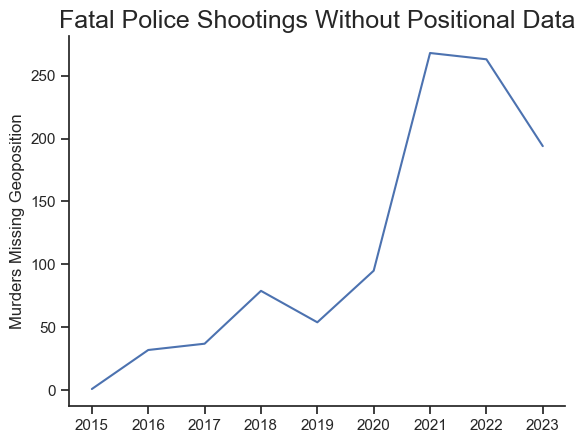

In [44]:
# plot missing data by year

missing_data = dict()

for chosen_year in year_list:
    chosen_year_filter = wapo['date'].dt.year == int(chosen_year)
    chosen_year_data = wapo[chosen_year_filter]

    missing_data[int(chosen_year)] = chosen_year_data[
        chosen_year_data['longitude'].isnull()].shape[0]

plt.plot(*zip(*sorted(missing_data.items())))
plt.title('Fatal Police Shootings Without Positional Data')
plt.ylabel('Murders Missing Geoposition')
plt.show()

plot bar chart of top 10 cities with dropdown menu for state 
plot bar chart for top 10 counties with dropdown menu for state 

In [45]:
location_grouped = wapo.sort_values(['state', 'county', 'city'])
location_grouped = location_grouped.groupby(['state', 'county', 'city'],
                                            observed=False).apply(lambda x: x)
location_grouped.drop(columns=['city', 'county', 'state'], inplace=True)
location_grouped = location_grouped.droplevel(3)

states = wapo['state'].unique().sort_values()

/var/folders/fw/n97s2lw13v7d0brxq53jt7xh0000gn/T/ipykernel_9550/3276724561.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [46]:
def plot_top_10_counties_and_cities(state='AK'):
    state_info = location_grouped.loc[state]
    state_info_reset = state_info.reset_index()
    county_counts = state_info_reset['county'].value_counts()
    city_counts = state_info_reset['city'].value_counts()

    print(
        f'The state of {state} has had {state_info.size} fatal police shootings from 2015-2023'
    )
    print("")
    print(
        f'The city with the most fatal police shootings in {state} is {city_counts.idxmax()} with {city_counts.max()} murders'
    )
    print("")
    print(
        f'The county with the most fatal police shootings in {state} is {county_counts.idxmax()} with {county_counts.max()} murders'
    )

    fig, axes = plt.subplots(nrows=2,
                             ncols=1,
                             figsize=(10, 8),
                             gridspec_kw={'hspace': 1})

    top_10_cities = city_counts[0:10]
    top_10_cities.plot(kind='bar', ax=axes[0], xlabel="", ylabel="Murders")
    axes[0].set_title(
        f'Top 10 Most Fatal Police Shootings by City in {state} \n 2015-2023')

    top_10_counties = county_counts[0:10]
    top_10_counties.plot(kind='bar', ax=axes[1], xlabel="", ylabel="Murders")
    axes[1].set_title(
        f'Top 10 Most Fatal Police Shootings by County in {state} \n 2015-2023')


interact(plot_top_10_counties_and_cities, state=states);

interactive(children=(Dropdown(description='state', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', '…

#### Some observations from interactive plot:
- Again, major population centers seem to have more police murders. 
- Again, California is a major outlier
    - Specifically, Los Angeles County and the City of Los Angeles appear to be a major outlier for the country and perhaps deserve a case-study.
- In comparison to California, New York appears to be quite safe.

## Now I would like to investigate this data both by race and by state

In [47]:
by_race_and_state = wapo.groupby(['race', 'state'],
                                 observed=False)['race'].count()
by_race_and_state = by_race_and_state.rename('counts', inplace=True)
by_race_and_state = by_race_and_state.reset_index()
races = by_race_and_state['race'].unique()
states = by_race_and_state['state'].unique()
by_race_and_state

,race,state,counts
0,Asian,AK,3
1,Asian,AL,0
2,Asian,AR,2
3,Asian,AZ,0
4,Asian,CA,51
...,...,...,...
352,unknown,VT,1
353,unknown,WA,50
354,unknown,WI,0
355,unknown,WV,18


In [48]:
def plot_race_by_state(race='Asian'):
    race_mask = by_race_and_state['race'].str.contains(f"{race}")
    by_race_and_state[race_mask].plot.bar(
        x='state',
        y='counts',
        figsize=(10, 3),
        title=f'Fatal Police Shootings of {race} Citizens By State \n (2015-2023)',
        ylabel='Murders',
        xlabel="",
        legend=False)


interact(plot_race_by_state, race=races);

interactive(children=(Dropdown(description='race', options=('Asian', 'Black', 'Hispanic', 'Native_American', '…

#### Some observations from interactive plot:
- Asian murders occur in California, Hawaii, and Washington primarily 
- Black murders occur in the deep south and California. Relative to population size, it appears that NY and NJ have less than might be expected. 
- Hispanic police shootings occur in along Mexican border and Florida. 
- the Non-reported Unknown category seems to be dominant in California.  

***
# Time Series Analysis 

In [49]:
# what years are in this data?

print(*years.unique())

2015 2016 2017 2018 2019 2020 2021 2022 2023


In [50]:
# How many murders occurred each year?

grouped_by_year = wapo.groupby(years)['agency_ids'].count()
grouped_by_year.rename('total_murders', inplace=True)
grouped_by_year.index.rename('year', inplace=True)
grouped_by_year

year
2015     995
2016     959
2017     984
2018     991
2019     994
2020    1020
2021    1049
2022    1095
2023    1164
Name: total_murders, dtype: int64

Text(0, 0.5, 'Total Police Murders')

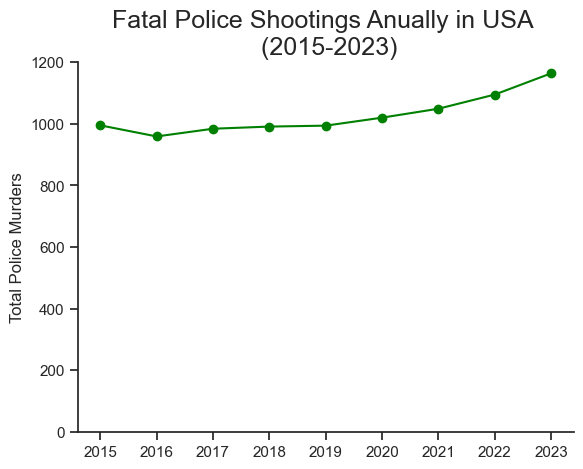

In [51]:
# plot murders by year as a line plot
Year = grouped_by_year.index
Total_Murders = grouped_by_year.values

# create a line chart, Years on x-axis, Total Police Murders on y-axis
plt.plot(Year, Total_Murders, color='green', marker='o', linestyle='solid')

# add a title
plt.title("Fatal Police Shootings Anually in USA \n (2015-2023)")

plt.ylim([0, 1200])

# add a label to the y-axis
plt.ylabel("Total Police Murders")

In [52]:
date_and_state = wapo[['date', 'state']]
month_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}


def plot_murders_by_month_per_state_for_year(state='WA', year=2015):
    state_df = date_and_state[date_and_state['state'] == state].copy()
    state_df.loc[:, 'month'] = state_df['date'].dt.month
    state_df = state_df[state_df['date'].dt.year == year]
    counts = state_df['month'].value_counts(sort=False)
    counts = counts.reindex(range(1, 13), fill_value=0)
    counts = counts.reset_index()
    counts['month'].replace(month_dict, inplace=True)
    ax = sns.lineplot(data=counts, x='month', y='count')
    plt.title(
        f'Fatal Police Shootings by Month in {state} for the Year {year}')
    plt.xlabel(None)
    plt.ylabel('Total Murders')
    plt.xticks(rotation=45)
    plt.ylim(0, 24)


# Create interactive widgets
state_widget = widgets.Dropdown(options=wapo['state'].unique().sort_values(),
                                value='WA',
                                description='State:')
year_widget = widgets.IntSlider(min=wapo['date'].dt.year.min(),
                                max=wapo['date'].dt.year.max(),
                                value=2015,
                                description='Year:')

# Use interact to make the function interactive
interact(plot_murders_by_month_per_state_for_year,
         state=state_widget,
         year=year_widget);

interactive(children=(Dropdown(description='State:', index=47, options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'C…

### Observations about interactive plot:
- this tool appears useful for exploration, but initially no particularly obvious trends jump out at me, except that California is on a different scale than most of the country.

# Other Factors: Body Cameras, Mental Health, were they fleeing or not?

In [53]:
# is any of the body camera data missing?

wapo['body_camera'].isna().any()

np.False_

In [54]:
body_cam_ratio = wapo['body_camera'].sum() / wapo['body_camera'].count()
print(
    f'Only {body_cam_ratio*100:.3f}% of the fatal police shootings from 2015-2023 have associated body camera footage.'
)

Only 16.831% of the fatal police shootings from 2015-2023 have associated body camera footage.


Text(40.308534432870374, 0.5, 'Murders')

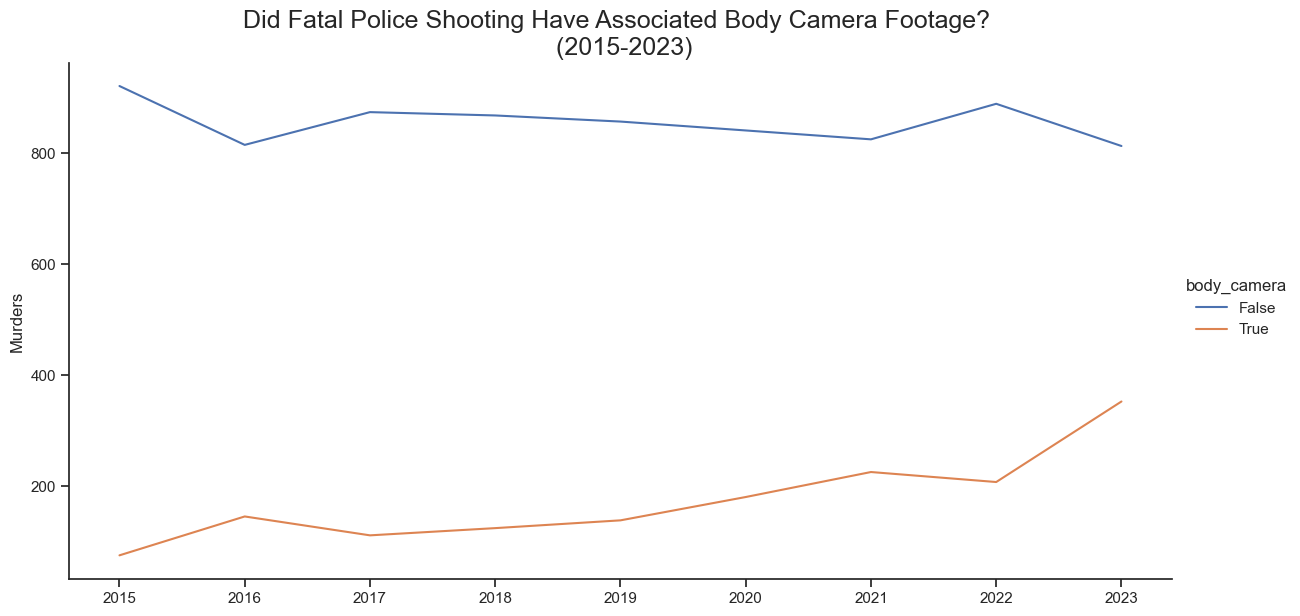

In [55]:
body_camera_by_year = wapo.groupby([years])['body_camera'].value_counts()
body_camera_by_year = body_camera_by_year.reset_index()
sns.relplot(data=body_camera_by_year,
            x='date',
            y='count',
            hue='body_camera',
            kind='line',
            height=6,
            aspect=2)
plt.title(
    'Did Fatal Police Shooting Have Associated Body Camera Footage? \n (2015-2023)'
)
plt.xlabel('')
plt.ylabel('Murders')

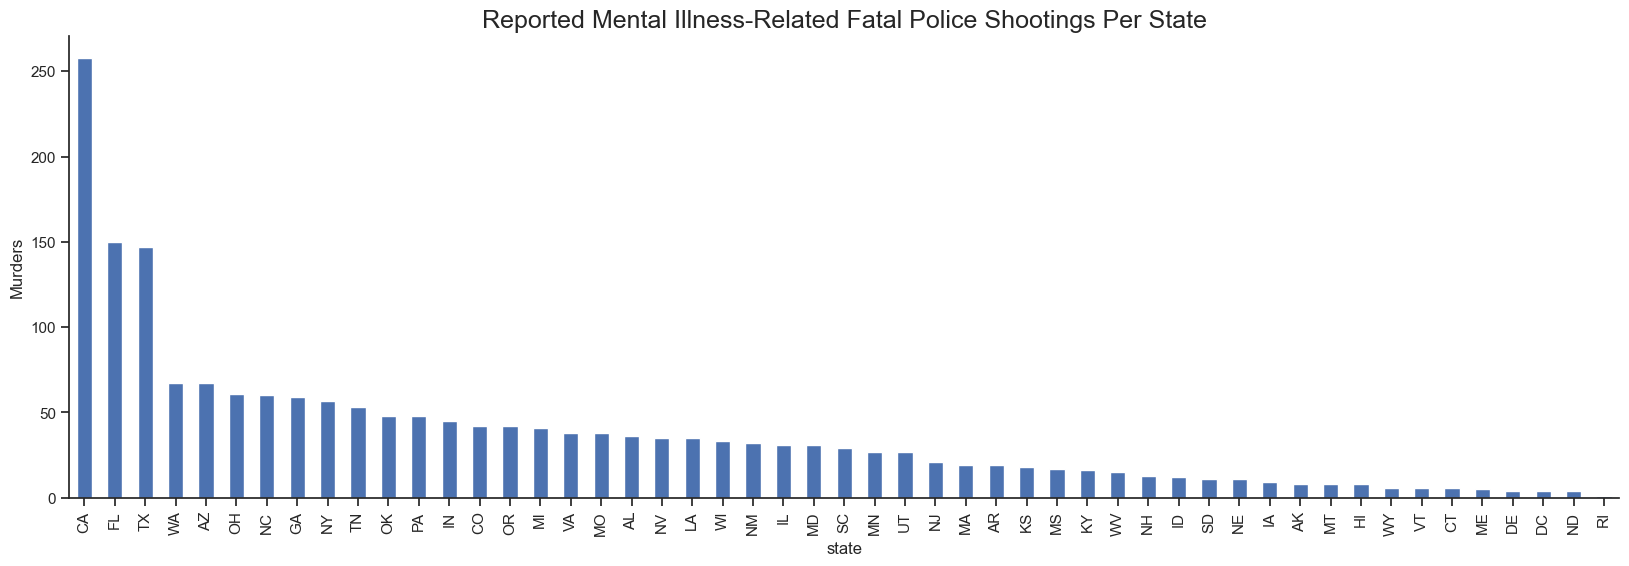

In [56]:
mental_illness_by_state = wapo[
    wapo['was_mental_illness_related']]['state'].value_counts()
mental_illness_by_state
plt.figure(figsize=(20, 6))
plt.title("Reported Mental Illness-Related Fatal Police Shootings Per State")
plt.ylabel("Murders")
mental_illness_by_state.plot(kind="bar");

In [57]:
# is any of the data missing for mental illness related deaths
print(wapo['was_mental_illness_related'].isnull().any())

False


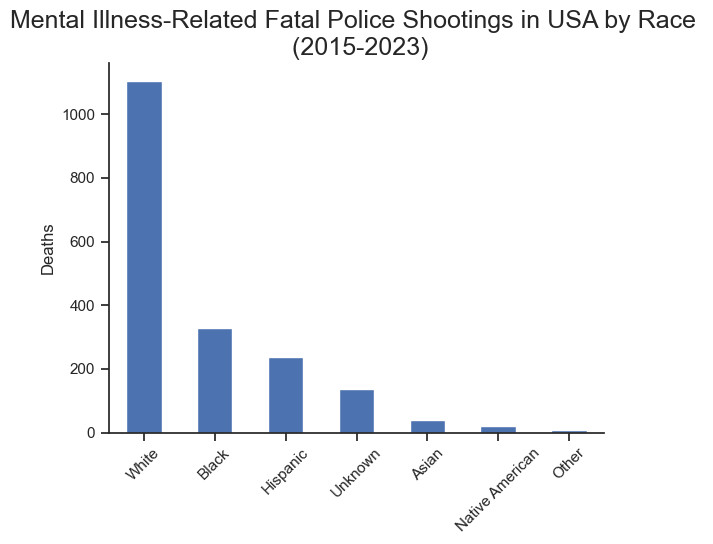

In [58]:
mental_illness = wapo[wapo['was_mental_illness_related']]
mental_illness_counts = mental_illness['race'].value_counts()
race_label_mapping = {
    'White': 'White',
    'Black': 'Black',
    'Hispanic': 'Hispanic',
    'unknown': 'Unknown',
    'Asian': 'Asian',
    'Native_American': 'Native American',
    'Other': 'Other'
}
mental_illness_counts.plot.bar(rot=45)

plt.ylabel("Deaths")
plt.xlabel(None)
plt.title(
    "Mental Illness-Related Fatal Police Shootings in USA by Race \n (2015-2023)"
)

# Set custom tick labels using the mapping
tick_labels = [
    race_label_mapping.get(label, label)
    for label in mental_illness_counts.index
]
plt.xticks(range(len(tick_labels)), tick_labels)

# Show the plot
plt.show()

In [59]:
wapo.flee_status.unique()

['not', 'car', 'foot', 'other', NaN]
Categories (4, object): ['car', 'foot', 'not', 'other']

In [60]:
not_fleeing = wapo[wapo['flee_status'] == 'not'].size / wapo.size

print(
    f"{not_fleeing * 100:.3f}% of the recorded fatal police shootings were of civilians who were not fleeing."
)

53.648% of the recorded fatal police shootings were of civilians who were not fleeing.


In [61]:
missing_fleeing = wapo[wapo['flee_status'].isna()].size / wapo.size

print(
    f"{missing_fleeing * 100:.3f}% of the recorded fatal police shootings did not record information about if the suspect was fleeing."
)

13.512% of the recorded fatal police shootings did not record information about if the suspect was fleeing.


In [62]:
# is there a relationship between race and the type of threat the officer reported?
# does one depend on the other?

# perform a Chi-Square Test of Independence

contingency_table = pd.crosstab(wapo['race'], wapo['threat_type'])
contingency_table.index = contingency_table.index.str.replace("_",
                                                              " ").str.title()
contingency_table.columns = contingency_table.columns.str.replace(
    "_", " ").str.title()
contingency_table

threat_type,Accident,Attack,Flee,Move,Point,Shoot,Threat,Undetermined
race,,,,,,,,
Asian,0,35,3,11,22,38,59,4
Black,16,356,49,110,344,735,522,84
Hispanic,13,247,40,92,240,375,478,48
Native American,0,19,3,9,27,25,39,7
Other,0,5,0,3,2,11,5,0
White,21,574,60,192,949,1165,1141,129
Unknown,1,105,18,33,147,260,271,44


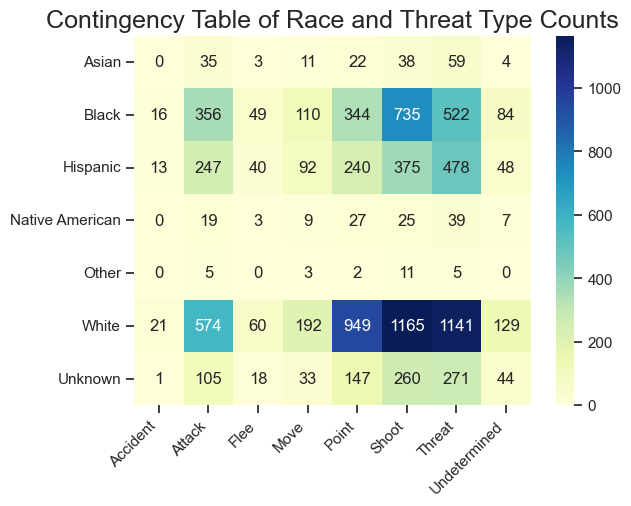

In [63]:
heatmap = sns.heatmap(contingency_table, cmap='YlGnBu', annot=True, fmt='d')

heatmap.set_xticklabels(contingency_table.columns, rotation=45, ha='right')
heatmap.set_yticklabels(contingency_table.index, rotation=0)

plt.title("Contingency Table of Race and Threat Type Counts")
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [64]:
chi2, p, _, expected = chi2_contingency(contingency_table)

print(
    f'''Comparing the indpendence of threat type and race provides a chi-squared test statistic = {chi2:.2f}, 
    with a significance level of p={p:.2e}. Therefore, these variables are unlikely to be independent.'''
)

Comparing the indpendence of threat type and race provides a chi-squared test statistic = 182.14, 
    with a significance level of p=2.27e-19. Therefore, these variables are unlikely to be independent.


In [65]:
# in order to assess significance we will look at the standardized residuals

residuals = (contingency_table - expected) / np.sqrt(expected)
residuals

threat_type,Accident,Attack,Flee,Move,Point,Shoot,Threat,Undetermined
race,,,,,,,,
Asian,-0.977206,1.973883,-0.132947,0.886797,-1.828789,-1.552543,1.735390,-0.788023
Black,1.053985,1.807046,1.124745,0.138544,-3.600755,4.209795,-3.439102,0.889840
Hispanic,1.538674,1.551373,2.071215,1.950404,-2.875723,-2.894689,2.845022,-0.652096
Native American,-0.846285,0.038758,0.366044,1.066336,0.545877,-1.922770,0.619489,1.216376
Other,-0.379934,0.618227,-0.699756,1.529651,-1.309899,1.330479,-0.794006,-0.945730
White,-0.513797,-1.756519,-2.204945,-1.060412,5.373056,-1.058264,-0.510925,-1.371580
Unknown,-1.756433,-2.058570,0.355345,-1.533079,-1.448156,0.654867,1.955884,2.502733


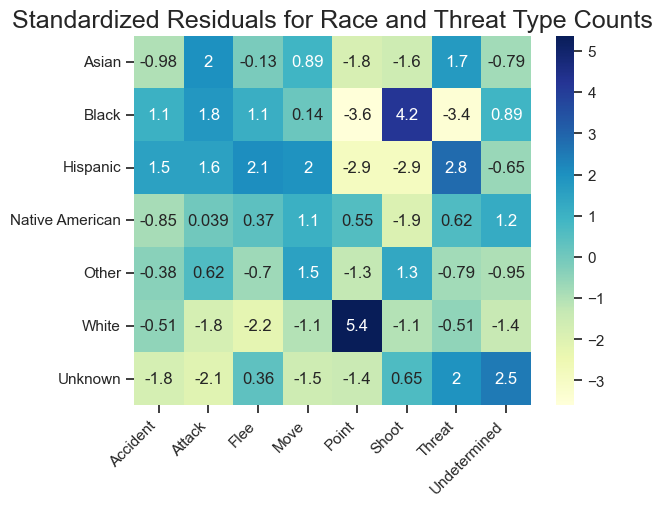

In [66]:
heatmap = sns.heatmap(residuals, cmap='YlGnBu', annot=True)

heatmap.set_xticklabels(contingency_table.columns, rotation=45, ha='right')
heatmap.set_yticklabels(contingency_table.index, rotation=0)

plt.title("Standardized Residuals for Race and Threat Type Counts")
plt.xlabel(None)
plt.ylabel(None)
plt.show()

Looking at some of the standout values it seems like there are less Black individuals Pointing or Threatening than expected, but more who are Shooting than expected, whereas there are more White indivudals who Pointing than expected. 

# Conclusions, Open Questions, and Future Directions
- The race category of "Unknown" (e.g. NaN values) has increased in recent years
- In recent years, we also see a tick of unreported cases
    - Does this hint at an increase in poorly documented police shootings more generally? 
- Can we merge similar datasets to look at not just police shootings, but also cases such as George Floyd's where the brutality that leads to murder is a different form of police violence? 
- California as a state and Los Angeles in particular seem to have an extremely high rate of police casualities. 
- New York is a populous state, yet has a much lower number of civilian deaths by police. 
- Texas might have changes in police shootings that correspond to changes in gun laws. 
- One interesting finding in our Chi-Square Test of Independence and Residual Analysis is that there are in fact less Black individuals who are threatening or pointing, but more that are shooting than expected.
    - Does this mean that officers are in fact using justified force in these situations?
    - Can we corroborate this with body camera footage? 
- I believe that this analysis could benefit from comparison with other datasets such as [Mapping Police Violence](https://mappingpoliceviolence.org/).
- Race statistics can be normalized based on their representation in the population.
- The geographic analysis would have benefitted from a normalization based on general population size.
- Could further explore Plotly, Folium, Geopandas and related API in more depth. 
    - Folium map has bug when plotting year 2023 that I could not solve (does not display data on map) 
- Could perform more interesting statistical analyses. 